# Introduction 

This Notebook will do the following things :
1. Create a portfolio based on Markowitz Model with Integer Optimization
2. Create a test on the portfolio for each 2 year

# Workflow 
0. Import useful package such as Numpy, Pandas, yfinance, scipy.optimize, matplotlib and seaborn.
1. Filter all the stocks with stocks that currently has positive mean return and has the same date.
2. Create portfolio.
3. Testing the portfolio that has been made.

# Packages

In [116]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf
from scipy.optimize import minimize
import seaborn as sn

# Initialize First Pick

In [117]:
stock = ['BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BBNI.JK', 'ARTO.JK', 'BBTN.JK','HRUM.JK', 'INCO.JK', 'ANTM.JK', 'ADRO.JK','TKIM.JK','SMGR.JK', 'TLKM.JK', 'UNVR.JK', 'ASII.JK', 'BRPT.JK', 'PTPP.JK', 'CTRA.JK', 'TOWR.JK']
year = 2022
ds = str(year-1)+'-12-01'
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '1y', start = ds, interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return
curr_ = df.describe().T
curr_ = curr_[curr_['mean']>0]
curr_stock = set(curr_.index)

In [118]:
stock = ['BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BBNI.JK', 'ARTO.JK', 'BBTN.JK','HRUM.JK', 'INCO.JK', 'ANTM.JK', 'ADRO.JK','TKIM.JK','SMGR.JK', 'TLKM.JK', 'UNVR.JK', 'ASII.JK', 'BRPT.JK', 'PTPP.JK', 'CTRA.JK', 'TOWR.JK']
year = 2020
ds = str(year-1)+'-12-01'
de = str(year+1)+'-12-01'
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '2y', start = ds, end=de, interval = '1mo',actions=False).dropna()[['Close']]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return
prev_ = df.describe().T
prev_ = prev_[prev_['mean']>0]
prev_stock = set(prev_.index)

In [119]:
stock = list(curr_stock)
#stock = list(curr_stock & prev_stock)
year = 2020
ds = str(year-1)+'-12-01'
de = str(year+1)+'-12-01'
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '2y', start = ds ,end =de ,interval = '1mo',actions=False).dropna()[['Close']]
    if temp.shape[0] == 25:
        log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
        df[i] = log_return

In [120]:
mu = df.mean().values
C = df.cov().values

def objective(weights): 
    weights = np.array(weights)
    return weights.dot(C).dot(weights.T)

# The constraints
cons = (
    {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
    #{"type": "ineq", "fun": lambda x: np.sum(mu*x)-0.03}
        )

bounds = tuple((0,1) for x in range(mu.shape[0]))
guess = [1./mu.shape[0] for x in range(mu.shape[0])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
x_ = np.round(optimized_results.x,4)

In [121]:
np.sum(np.round(x_,5))

1.0

In [122]:
port_ = dict(zip(stock,np.round(x_,5)))
port = dict()
for (key,value) in port_.items():
    if value >0 : 
        port[key] = value
port

{'UNVR.JK': 0.4325, 'BBCA.JK': 0.3271, 'TOWR.JK': 0.1112, 'ADRO.JK': 0.1292}

In [123]:
start = 2e7 
budget_ = dict()
for (key,value) in port.items():
    if value >0 : 
        budget_[key] = value*start
budget_

{'UNVR.JK': 8650000.0,
 'BBCA.JK': 6542000.0,
 'TOWR.JK': 2224000.0,
 'ADRO.JK': 2584000.0}

In [124]:
budget = pd.DataFrame.from_dict(data= budget_, orient= 'index').T
budget.rename(index={0: 'Total Spread'}, inplace= True)
budget

,UNVR.JK,BBCA.JK,TOWR.JK,ADRO.JK
Total Spread,8650000.0,6542000.0,2224000.0,2584000.0


In [125]:
expense = pd.DataFrame(columns=port.keys())
for item in port.keys(): 
    temp = yf.Ticker(item).history(period = '1d', interval = '1mo',actions=False)
    expense[item] = temp['Close']*100 #1 lot
expense.rename(index={expense.index[0]: str('Closing ' + str(expense.index[0]).split(' ')[0])}, inplace= True)
expense

,UNVR.JK,BBCA.JK,TOWR.JK,ADRO.JK
Date,,,,
Closing 2022-09-16,463000.0,845000.0,119000.0,393000.0


In [126]:
qty = pd.concat([expense,budget])
temp_ = pd.DataFrame(np.round(qty.iloc[1] / qty.iloc[0],0)).T
temp_.rename(index={0: 'Total Lot'}, inplace= True)
qty = pd.concat([qty, temp_])
spend = pd.DataFrame(np.round(qty.iloc[2] * qty.iloc[0],0)).T
finale = pd.concat([qty, spend])
finale.rename(index={0: 'Total Spending'}, inplace= True)
finale

,UNVR.JK,BBCA.JK,TOWR.JK,ADRO.JK
Closing 2022-09-16,463000.0,845000.0,119000.0,393000.0
Total Spread,8650000.0,6542000.0,2224000.0,2584000.0
Total Lot,19.0,8.0,19.0,7.0
Total Spending,8797000.0,6760000.0,2261000.0,2751000.0


In [127]:
finale.sum(axis = 1)

Closing 2022-09-16     1820000.0
Total Spread          20000000.0
Total Lot                   53.0
Total Spending        20569000.0
dtype: float64

In [128]:
print(f'return :', x_.dot(mu)*100, '%')
print(f'risk :', x_.dot(C).dot(x_)*100, '%')
print(f'Total Money :',finale.sum(axis=1)[-1])
print(f'Total Idle Money :', start - finale.sum(axis=1)[-1])

return : -0.5366820699155337 %
risk : 0.21293986988888117 %
Total Money : 20569000.0
Total Idle Money : -569000.0


In [129]:
df[finale.columns]

,UNVR.JK,BBCA.JK,TOWR.JK,ADRO.JK
Date,,,,
2020-01-01,-0.044974,-0.027986,0.056581,-0.238535
2020-02-01,-0.152580,-0.029760,-0.048494,-0.014053
2020-03-01,0.060409,-0.129678,-0.176130,-0.154151
2020-04-01,0.132237,-0.066411,0.287682,-0.073331
2020-05-01,-0.065546,0.021001,0.059317,0.178692
2020-06-01,0.019170,0.092855,0.087209,-0.100323
2020-07-01,0.061369,0.091392,0.106830,0.125208
2020-08-01,-0.021053,0.005593,-0.092231,0.000000
2020-09-01,-0.002220,-0.146478,0.000000,0.045053


In [130]:
test = pd.DataFrame(columns = finale.columns)
for i in finale.columns :
    temp = yf.Ticker(i).history(period = '1y', start = '2021-12-31', interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    test[i] = log_return

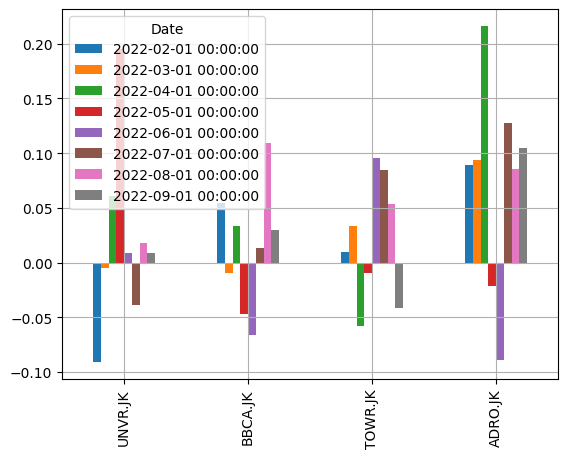

In [131]:
test.T.plot.bar()
plt.grid(True)
plt.show()

In [132]:
ports = [x_[i] for i in range(len(x_)) if x_[i]>0]
ports

[0.4325, 0.3271, 0.1112, 0.1292]

In [133]:
test['total_return'] = test.dot(ports)
test

,UNVR.JK,BBCA.JK,TOWR.JK,ADRO.JK,total_return
Date,,,,,
2022-02-01,-0.090854,0.054240,0.009709,0.089612,-0.008895
2022-03-01,-0.005450,-0.009360,0.033257,0.093453,0.010354
2022-04-01,0.060946,0.033844,-0.057708,0.216430,0.058975
2022-05-01,0.195516,-0.047253,-0.009950,-0.021181,0.065261
2022-06-01,0.008421,-0.066691,0.095310,-0.088922,-0.019063
2022-07-01,-0.038969,0.013699,0.084697,0.127833,0.013561
2022-08-01,0.017583,0.109434,0.053843,0.085472,0.060431
2022-09-01,0.008677,0.030032,-0.041158,0.104513,0.022503


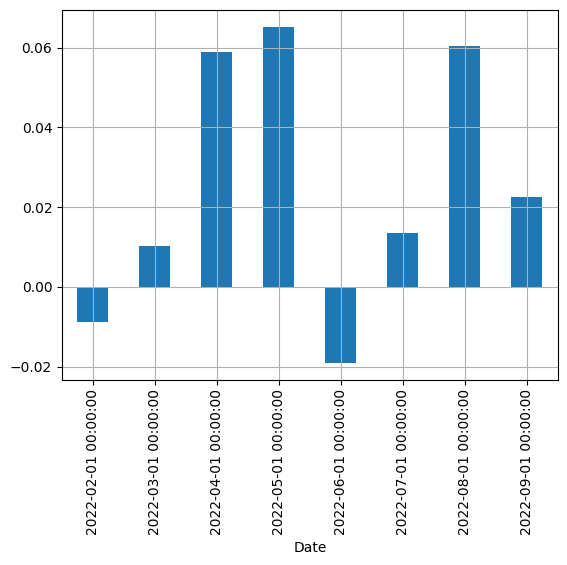

In [134]:
test.total_return.plot.bar()
plt.grid(True)
plt.show()

In [14]:
finale.to_csv(str('IHSG '+finale.index[0].split(' ')[1]+'.csv'))

# Testing Profit

In [137]:
stock = ['BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BBNI.JK', 'ARTO.JK', 'BBTN.JK','HRUM.JK', 
         'INCO.JK', 'ANTM.JK', 'ADRO.JK','TKIM.JK','SMGR.JK', 'TLKM.JK', 'UNVR.JK', 
         'ASII.JK', 'BRPT.JK', 'PTPP.JK', 'CTRA.JK', 'TOWR.JK']
year = 2010
ds = str(year-1)+'-12-01'
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '1y', start = ds, interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return
curr_ = df.describe().T
curr_ = curr_[curr_['mean']>0]
curr_stock = set(curr_.index)

In [143]:
year = 2010
ds = str(year-1)+'-12-01'
de = str(year+1)+'-12-01'

stock = list(curr_stock)
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '2y', start = ds ,end =de ,interval = '1mo',actions=False).dropna()[['Close']]
    if temp.shape[0] == 25:
        log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
        df[i] = log_return
df.dropna(axis = 1, inplace = True)

- ARTO.JK: Data doesn't exist for startDate = 1259600400, endDate = 1322672400


In [144]:
mu = df.mean().values
C = df.cov().values

def objective(weights): 
    weights = np.array(weights)
    return weights.dot(C).dot(weights.T)
# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.# The expected daily return of our portfolio and we want to be at greater than 0.002352
        #{"type": "ineq", "fun": lambda x: np.sum(mu*x)-0.06}
        )
bounds = tuple((0,1) for x in range(mu.shape[0]))
guess = [1./mu.shape[0] for x in range(mu.shape[0])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
x_ = np.round(optimized_results.x,4)

In [145]:
print(np.sum(np.round(x_,5)))
print(f'return :', x_.dot(mu)*100, '%')
print(f'risk :', x_.dot(C).dot(x_)*100, '%')
print(f'Total Money :',finale.sum(axis=1)[-1])
print(f'Total Idle Money :', start - finale.sum(axis=1)[-1])

1.0
return : 0.5771013201815051 %
risk : 0.01878118599325942 %
Total Money : 20569000.0
Total Idle Money : -569000.0


In [146]:
port_ = dict(zip(df.columns.values,np.round(x_,5)))
port = dict()
for (key,value) in port_.items():
    if value >0 : 
        port[key] = value
start = 2e7 
budget_ = dict()
for (key,value) in port.items():
    if value >0 : 
        budget_[key] = value*start
budget = pd.DataFrame.from_dict(data= budget_, orient= 'index').T
budget.rename(index={0: 'Total Spread'}, inplace= True)
expense = pd.DataFrame(columns=port.keys())

bs = str(year+2)+'-12-31'
be = str(year+3)+'-01-01'
for item in port.keys(): 
    temp = yf.Ticker(item).history(period = '1d', start = bs, end = be, interval = '1mo',actions=False)
    expense[item] = temp['Close']*100 #1 lot
expense.rename(index={expense.index[0]: str('Closing ' + str(expense.index[0]).split(' ')[0])}, inplace= True)
qty = pd.concat([expense,budget])
temp_ = pd.DataFrame(np.round(qty.iloc[1] / qty.iloc[0],0)).T
temp_.rename(index={0: 'Total Lot'}, inplace= True)
qty = pd.concat([qty, temp_])
spend = pd.DataFrame(np.round(qty.iloc[2] * qty.iloc[0],0)).T
finale = pd.concat([qty, spend])
finale.rename(index={0: 'Total Spending'}, inplace= True)
finale

,BBRI.JK,BBNI.JK,SMGR.JK
Closing 2013-01-01,120439.660645,1.390727e+05,1.257134e+06
Total Spread,902000.000000,1.901300e+07,8.500000e+04
Total Lot,7.000000,1.370000e+02,0.000000e+00
Total Spending,843078.000000,1.905296e+07,0.000000e+00


In [147]:
buy = finale.columns.values
bs = str(year+2)+'-12-31'
be = str(year+4)+'-01-01'
profit_test = pd.DataFrame()
for item in buy:
    temp = yf.Ticker(item).history(period = '1y', start = bs, end = be, interval = '1mo',actions=False)
    temp.dropna(inplace = True)
    temp['buy_'+item] = finale[item].loc['Total Lot'] * temp['Open'] * 100
    temp['sell_'+item] = finale[item].loc['Total Lot'] * temp['Close'] * 100
    profit_test['buy_'+item] = temp['buy_'+item].dropna()
    profit_test['sell_'+item] = temp['sell_'+item].dropna()
    profit_test['return_'+item] =  profit_test['sell_'+item].iloc[1:] - profit_test['buy_'+item].iloc[:-1]
profit_test.dropna(inplace = True)
profit_test


,buy_BBRI.JK,sell_BBRI.JK,return_BBRI.JK,buy_BBNI.JK,sell_BBNI.JK,return_BBNI.JK,buy_SMGR.JK,sell_SMGR.JK,return_SMGR.JK
Date,,,,,,,,,
2013-02-01,8.483801e+05,1.002149e+06,153768.886538,1.905296e+07,1.905296e+07,0.000000e+00,0.0,0.0,0.0
2013-03-01,9.756371e+05,9.279157e+05,-47721.379395,1.905296e+07,1.905296e+07,0.000000e+00,0.0,0.0,0.0
2013-04-01,9.501496e+05,1.020732e+06,70582.539140,1.905296e+07,5.501925e+07,3.596629e+07,0.0,0.0,0.0
2013-05-01,1.031591e+06,9.664378e+05,-65153.107170,5.621018e+07,5.074530e+07,-5.464879e+06,0.0,0.0,0.0
2013-06-01,9.610082e+05,8.415608e+05,-119447.341545,5.100553e+07,4.475996e+07,-6.245575e+06,0.0,0.0,0.0
2013-07-01,8.415610e+05,8.958552e+05,54294.257517,4.502020e+07,4.449973e+07,-5.204647e+05,0.0,0.0,0.0
2013-08-01,8.904258e+05,7.166842e+05,-173741.617839,4.475995e+07,4.007577e+07,-4.684181e+06,0.0,0.0,0.0
2013-09-01,7.166841e+05,7.872666e+05,70582.526182,3.955531e+07,4.241787e+07,2.862555e+06,0.0,0.0,0.0
2013-10-01,7.872666e+05,8.578491e+05,70582.524630,4.267810e+07,4.996460e+07,7.286504e+06,0.0,0.0,0.0


In [148]:
cols = profit_test.columns
finale_pt = pd.DataFrame()
tspend = 0
tprofit = 0 
for k in range (0,profit_test.shape[1], 3):
    tspend += profit_test[cols[k]]
    tprofit += profit_test[cols[k+2]]
finale_pt['Total Spending'] = tspend
finale_pt['Total Profit'] = tprofit
finale_pt['Total Return'] = finale_pt['Total Profit']/finale_pt['Total Spending']
finale_pt

,Total Spending,Total Profit,Total Return
Date,,,
2013-02-01,1.990134e+07,1.537689e+05,0.007727
2013-03-01,2.002860e+07,-4.772138e+04,-0.002383
2013-04-01,2.000311e+07,3.603687e+07,1.801563
2013-05-01,5.724177e+07,-5.530032e+06,-0.096608
2013-06-01,5.196654e+07,-6.365023e+06,-0.122483
2013-07-01,4.586176e+07,-4.661704e+05,-0.010165
2013-08-01,4.565038e+07,-4.857923e+06,-0.106416
2013-09-01,4.027199e+07,2.933138e+06,0.072833
2013-10-01,4.346536e+07,7.357087e+06,0.169263


In [149]:
print(f'Keuntungan dalam satu tahun pada tahun {year+3} sebesar:', finale_pt['Total Return'].mean()*100,'%')

Keuntungan dalam satu tahun pada tahun 2013 sebesar: 14.041058044226476 %


# Loop

In [150]:
year = 2010
for n in range(8):
    year += 1
    ds = str(year-1)+'-12-01'
    de = str(year+1)+'-12-01'

    stock = ['TLKM.JK', 'BBNI.JK','ASII.JK', 'ANTM.JK', 'BMRI.JK','BBRI.JK', 'ARTO.JK', 'UNVR.JK', 'AMRT.JK', 'HRUM.JK',
            'BBCA.JK', 'INCO.JK', 'ADRO.JK', 'PTBA.JK', 'PGAS.JK']
    #stock = ['TSLA', 'DIS', 'NKE', 'AAPL']
    df = pd.DataFrame(columns=stock)
    for i in stock :
        temp = yf.Ticker(i).history(period = '2y', start = ds ,end =de ,interval = '1mo',actions=False)
        temp.dropna(inplace = True)
        temp['log_return'] = np.log(temp['Close']) - np.log(temp['Close'].shift(1))
        temp['log_return'].dropna(inplace = True)
        df[i] =temp['log_return'].dropna()
    df.dropna(axis = 1, inplace = True)

    mu = df.mean().values
    C = df.cov().values

    def objective(weights): 
        weights = np.array(weights)
        return weights.dot(C).dot(weights.T)
    # The constraints
    cons = (# The weights must sum up to one.
            {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
            # This constraints says that the inequalities (ineq) must be non-negative.# The expected daily return of our portfolio and we want to be at greater than 0.002352
            #{"type": "ineq", "fun": lambda x: np.sum(mu*x)-0.06}

            )
    # Every stock can get any weight from 0 to 1
    bounds = tuple((0,1) for x in range(mu.shape[0]))
    # Initialize the weights with an even split
    # In out case each stock will have 10% at the beginning
    guess = [1./mu.shape[0] for x in range(mu.shape[0])]
    optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
    x_ = optimized_results.x
    print(np.sum(np.round(x_,5)))
    print(f'return :', x_.dot(mu)*100, '%')
    print(f'risk :', x_.dot(C).dot(x_)*100, '%')
    print(f'Total Money :',finale.sum(axis=1)[-1])
    print(f'Total Idle Money :', start - finale.sum(axis=1)[-1])
    port_ = dict(zip(df.columns.values,np.round(x_,5)))
    port = dict()
    for (key,value) in port_.items():
        if value >0 : 
            port[key] = value
    start = 2e7 
    budget_ = dict()
    for (key,value) in port.items():
        if value >0 : 
            budget_[key] = value*start
    budget = pd.DataFrame.from_dict(data= budget_, orient= 'index').T
    budget.rename(index={0: 'Total Spread'}, inplace= True)
    expense = pd.DataFrame(columns=port.keys())

    bs = str(year+2)+'-12-31'
    be = str(year+3)+'-01-01'

    for item in port.keys(): 
        temp = yf.Ticker(item).history(period = '1d', start = bs, end = be, interval = '1mo',actions=False)
        expense[item] = temp['Close']*100 #1 lot
    expense.rename(index={expense.index[0]: str('Closing ' + str(expense.index[0]).split(' ')[0])}, inplace= True)
    qty = pd.concat([expense,budget])
    temp_ = pd.DataFrame(np.round(qty.iloc[1] / qty.iloc[0],0)).T
    temp_.rename(index={0: 'Total Lot'}, inplace= True)
    qty = pd.concat([qty, temp_])
    spend = pd.DataFrame(np.round(qty.iloc[2] * qty.iloc[0],0)).T
    finale = pd.concat([qty, spend])
    finale.rename(index={0: 'Total Spending'}, inplace= True)
    finale
    buy = finale.columns.values
    bs = str(year+2)+'-12-31'
    be = str(year+4)+'-01-01'
    profit_test = pd.DataFrame()
    for item in buy:
        temp = yf.Ticker(item).history(period = '1y', start = bs, end = be, interval = '1mo',actions=False)
        temp.dropna(inplace = True)
        temp['buy_'+item] = finale[item].loc['Total Lot'] * temp['Open'] * 100
        temp['sell_'+item] = finale[item].loc['Total Lot'] * temp['Close'] * 100
        profit_test['buy_'+item] = temp['buy_'+item].dropna()
        profit_test['sell_'+item] = temp['sell_'+item].dropna()
        profit_test['return_'+item] =  profit_test['sell_'+item].iloc[1:] - profit_test['buy_'+item].iloc[:-1]
    profit_test.dropna(inplace = True)
    cols = profit_test.columns
    finale_pt = pd.DataFrame()
    tspend = 0
    tprofit = 0 
    for k in range (0,profit_test.shape[1], 3):
        tspend += profit_test[cols[k]]
        tprofit += profit_test[cols[k+2]]
    finale_pt['Total Spending'] = tspend
    finale_pt['Total Profit'] = tprofit
    finale_pt['Total Return'] = finale_pt['Total Profit']/finale_pt['Total Spending']
    finale_pt.to_csv('Profit Test' +str(year)+'.csv')
    print(f'Rata-rata satu tahun keuntungan perbulan pada tahun {year+3} sebesar:', finale_pt['Total Return'].mean()*100,'%')

- ARTO.JK: Data doesn't exist for startDate = 1291136400, endDate = 1354294800
1.0
return : 0.273201287316306 %
risk : 0.009621628000429826 %
Total Money : 19896040.0
Total Idle Money : 103960.0
Rata-rata satu tahun keuntungan perbulan pada tahun 2014 sebesar: 3.145126777407882 %
- ARTO.JK: Data doesn't exist for startDate = 1322672400, endDate = 1385830800
0.9999999999999999
return : 0.5447659357856405 %
risk : 0.10469324892896427 %
Total Money : 19964087.0
Total Idle Money : 35913.0
Rata-rata satu tahun keuntungan perbulan pada tahun 2015 sebesar: -1.6849628729245452 %
- ARTO.JK: Data doesn't exist for startDate = 1354294800, endDate = 1417366800
1.0
return : 0.7170682610429044 %
risk : 0.0637416700311901 %
Total Money : 20466818.0
Total Idle Money : -466818.0
Rata-rata satu tahun keuntungan perbulan pada tahun 2016 sebesar: 3.4039074462795367 %
- ARTO.JK: Data doesn't exist for startDate = 1385830800, endDate = 1448902800
1.00002
return : 0.9957671812312859 %
risk : 0.09221136409973